In [11]:
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pandas as pd
from collections import defaultdict

In [2]:
import os
print(os.getcwd())


/workspace


In [19]:
# Wczytanie danych
df = pd.read_csv("project_Data_Anal/tennis/dataset/tennis_data_2001_2025_FIXED.csv", low_memory=False)

# Konwersja daty
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

match_to_date = {
    (row['Winner'], row['Loser'], row['Surface']): row['Date']
    for _, row in df.iterrows()
}

# Usunięcie roku 2020
df = df[df['Date'].dt.year != 2020]

# Wybór i czyszczenie danych
df = df[['Winner', 'Loser', 'Surface', 'WPts', 'LPts', 'AvgW', 'AvgL']]

# Usuwamy mecze z brakami w punktach i kursach
df = df.dropna(subset=['WPts', 'LPts', 'AvgW', 'AvgL'])

# Usuń mecze na nawierzchni 'Carpet'
df = df[~df['Surface'].str.lower().eq('carpet')]

# Zamiana nazw graczy na ID
unique_players = pd.unique(df[['Winner', 'Loser']].values.ravel())
player_to_id = {player: i+1 for i, player in enumerate(unique_players)}
id_to_player = {v: k for k, v in player_to_id.items()}

df['p1'] = df['Winner'].map(player_to_id)
df['p2'] = df['Loser'].map(player_to_id)
df['y'] = 1  # p1 to zwycięzca

stan_df = df

# Dopasuj daty do stan_df (w razie czego można lepiej klucze znormalizować)
stan_df['Date'] = stan_df.apply(
    lambda row: match_to_date.get((row['Winner'], row['Loser'], row['Surface'])),
    axis=1
)

train_df = stan_df[stan_df['Date'].dt.year <= 2023].copy()
test_df = stan_df[stan_df['Date'].dt.year >= 2024].copy()

# Finalny DataFrame


In [20]:
points_per_player = defaultdict(list)

# Zbieramy punkty z obu stron (zwycięzcy i przegrani)
for _, row in train_df.iterrows():
    if row['WPts'] > 0:
        points_per_player[row['p1']].append(row['WPts'])
    if row['LPts'] > 0:
        points_per_player[row['p2']].append(row['LPts'])

# Obliczamy średnią liczbę punktów rankingowych
nPlayers = len(player_to_id)
player_strength = np.zeros(nPlayers)

for pid in range(1, nPlayers + 1):
    pts = points_per_player.get(pid, [])
    if pts:
        player_strength[pid - 1] = np.mean(pts)
    else:
        player_strength[pid - 1] = 0.0  # jeśli nie mamy danych → 0




09:19:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:15:48 - cmdstanpy - INFO - CmdStan done processing.


11:15:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 248 iterations at max treedepth (24.8%)
	Chain 3 had 221 iterations at max treedepth (22.1%)
	Chain 4 had 252 iterations at max treedepth (25.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


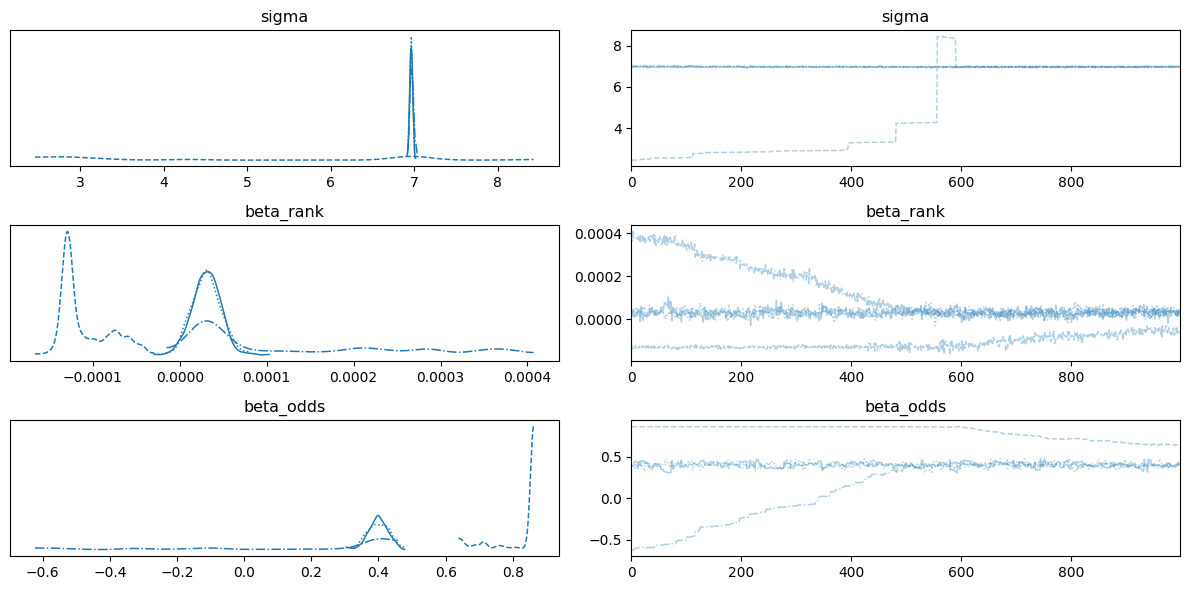

In [ ]:
model = CmdStanModel(stan_file='project_Data_Anal/tennis/model_elo.stan')

# Oblicz logitowe wartości punktów
train_df['p1Logit'] = np.log(train_df['WPts'])
train_df['p2Logit'] = np.log(train_df['LPts'])

# Oblicz oddsDiff z kursów bukmacherskich
train_df['oddsDiff'] = np.log(1 / train_df['AvgW']) - np.log(1 / train_df['AvgL'])

# Przygotuj siłę graczy z rankingu (np. odwrotność rankingu ATP)
# Upewnij się, że masz player_strength jako słownik lub wektor
# Zakładamy, że masz wcześniej przygotowane:
# player_strength = np.array([...])  # o długości nPlayers

stan_data_all = {
    'nGames': len(train_df),
    'nPlayers': len(player_to_id),
    'player1': train_df['p1'].tolist(),
    'player2': train_df['p2'].tolist(),
    'p1Logit': train_df['p1Logit'].tolist(),
    'p2Logit': train_df['p2Logit'].tolist(),
    'oddsDiff': train_df['oddsDiff'].tolist(),
    'playerStrength': player_strength.tolist()
}

# Uruchom próbki z modelu
fit = model.sample(
    data=stan_data_all,
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=123
)

# Konwersja do formatu ArviZ
idata = az.from_cmdstanpy(posterior=fit)

# Trace plot tylko dla parametrów modelowanych
az.plot_trace(idata, var_names=["sigma", "beta_rank", "beta_odds"])
plt.tight_layout()
plt.show()

In [17]:
# Załaduj posterior
beta_rank_samples = idata.posterior['beta_rank'].stack(samples=("chain", "draw")).values
beta_odds_samples = idata.posterior['beta_odds'].stack(samples=("chain", "draw")).values

# Przygotuj dane dla nowego meczu
def predict_win_probability(p1_id, p2_id, avgW, avgL, player_strength):
    strength_diff = player_strength[p1_id - 1] - player_strength[p2_id - 1]
    odds_diff = np.log(1 / avgW) - np.log(1 / avgL)

    # logit dla każdej próbki posteriora
    logits = beta_rank_samples * strength_diff + beta_odds_samples * odds_diff
    probs = 1 / (1 + np.exp(-logits))  # sigmoid

    # Średnie i przedział ufności
    p_mean = np.mean(probs)
    p_ci_lower = np.percentile(probs, 2.5)
    p_ci_upper = np.percentile(probs, 97.5)

    return p_mean, p_ci_lower, p_ci_upper


p_mean, ci_low, ci_high = predict_win_probability(
    p1_id=player_to_id['Djokovic N.'],
    p2_id=player_to_id['Sinner J.'],
    avgW=1.90, avgL=1.95,
    player_strength=player_strength
)

print(f"Prawdopodobieństwo wygranej Djokovica: {p_mean:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})")

Prawdopodobieństwo wygranej Djokovica: 0.526 (95% CI: 0.313–0.884)
